In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.append("../")

import torch


from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config
from nupic.research.frameworks.continuous_learning.correlation_metrics import register_act, plot_metrics
from nupic.research.frameworks.continuous_learning.utils import get_act, dc_grad

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def clear_labels(labels):
    indices = np.arange(11)
    out = np.delete(indices, labels)
    return out

In [3]:
config_file = "../experiments.cfg"
with open(config_file) as cf:
    config_init = parse_config(cf)

exp = "sparseCNN2"

sparse_output=True
layers_ = ["cnn1_kwinner", "cnn2_kwinner", "linear1_kwinners"]
if sparse_output:
    layer_type = "kwinner"
else:
    layer_type = "dense"

train_inds = np.arange(1,5).reshape(2,2)

results_ = np.zeros((len(train_inds), len(layers_)+1+int(sparse_output), len(train_inds.flatten())))
comp_results = np.zeros((len(train_inds), len(layers_)+1+int(sparse_output)))

for i in range(len(layers_)+1+int(sparse_output)):
    config = config_init[exp]
    config["name"] = exp
    config["seed"] = np.random.randint(0,200)
    config["cnn_out_channels"] = (256, 256)
    if sparse_output:
        config["linear_n"] = (2000,11)
        config["linear_percent_on"] = (0.1, 0.2)
        config["weight_sparsity"] = (0.1, 0.1)
    else:
        config["linear_n"] = (2000,)

    config["batch_size"] = 64    
    # config["boost_strength"] = 0.0
    # config["boost_strength_factor"] = 0.0
    config["duty_cycle_period"] = 1000

    experiment = ContinuousSpeechExperiment(config)

    if i > len(layers_)-1:
        freeze_params=layers_
    else:
        freeze_params=[layers_[i]]

    for j in range(len(train_inds)):

        if j == 0:
            experiment.train(1,train_inds[j],
                            freeze_output=True,
                            layer_type=layer_type,
                            output_indices=clear_labels(train_inds[j]))
        else:
            experiment.train(2,train_inds[j],freeze_params=freeze_params,
                            freeze_fun=dc_grad,
                            freeze_pct=90,
                            freeze_output=True,
                            layer_type=layer_type,
                            output_indices=clear_labels(train_inds[j]))

        acc_ = [experiment.test_class(k)["mean_accuracy"] for k in train_inds.flatten()]

#         print("trained classes {}: {:.2f}".format(train_inds[j], [k for k in acc_]))

        results_[j,i,:] = acc_
        comp_results[j,i] = np.mean(acc_)

print(layer_type)

Creating optimizer with learning rate= 0.01
Creating optimizer with learning rate= 0.01
Creating optimizer with learning rate= 0.01
Creating optimizer with learning rate= 0.01
Creating optimizer with learning rate= 0.01
kwinner


/home/ec2-user/miniconda3/envs/nupic.research/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/ec2-user/miniconda3/envs/nupic.research/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


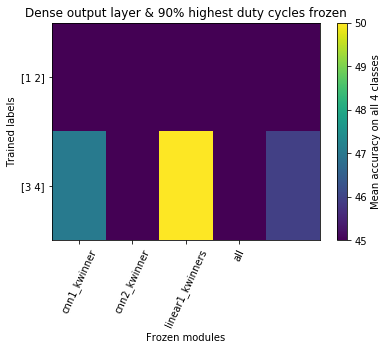

In [10]:
plt.figure()
plt.imshow(comp_results, aspect="auto", cmap="viridis")
plt.clim((45.,50.))
cbar = plt.colorbar()
cbar.set_label("Mean accuracy on all 4 classes")
plt.xticks(range(len(layers_)+1), layers_ + ["all"], rotation=65)
plt.yticks(range(2), train_inds);
plt.xlabel("Frozen modules")
plt.ylabel("Trained labels")
plt.title("Dense output layer & 90% highest duty cycles frozen")
plt.savefig("../plots/duty_cycle_weight_freezing/{}_output_90pct_dc.pdf".format(layer_type))

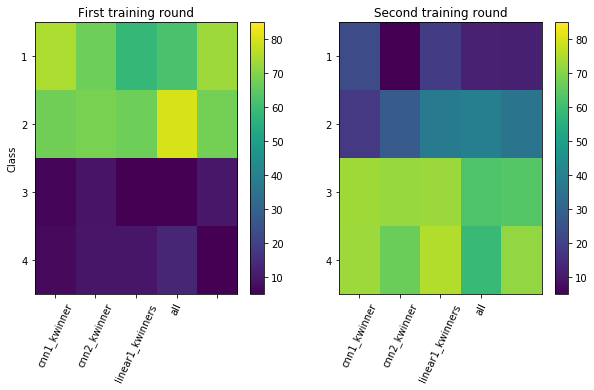

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(results_[0,:,:].T, aspect="auto")
plt.xticks(range(len(layers_)+2), layers_ + ["all"], rotation=65)
plt.yticks(range(4), train_inds.flatten());
plt.ylabel("Class")
plt.clim((5., 85))
plt.title("First training round")
plt.colorbar();

plt.subplot(1,2,2)
plt.imshow(results_[1,:,:].T, aspect="auto")
plt.xticks(range(len(layers_)+1), layers_ + ["all"], rotation=65)
plt.yticks(range(4), train_inds.flatten());
plt.clim((5., 85))
plt.title("Second training round")
plt.colorbar();

plt.savefig("../plots/duty_cycle_weight_freezing/{}_output_90pct_dc_perclass.pdf".format(layer_type))

In [45]:
train_inds = [1,2]
experiment.train(1, train_inds)

In [46]:
print(experiment.test_class(1)["mean_accuracy"], experiment.test_class(2)["mean_accuracy"])

80.80000000000001 77.01612903225806


In [47]:
train_indices = [3,4]
experiment.train(2, train_indices, freeze_params=["cnn2_kwinner"],
                 freeze_fun=dc_grad, freeze_pct=90)

In [48]:
print(experiment.test_class(1)["mean_accuracy"], experiment.test_class(2)["mean_accuracy"])

4.0 25.0


In [49]:
print(experiment.test_class(3)["mean_accuracy"], experiment.test_class(4)["mean_accuracy"])

79.16666666666666 67.41573033707866


In [50]:
train_indices = [5,6]
experiment.train(3, train_indices, freeze_params=["cnn2_kwinner"],
                freeze_fun=dc_grad, freeze_pct=90)

In [51]:
print(experiment.test_class(3)["mean_accuracy"], experiment.test_class(4)["mean_accuracy"])

29.545454545454547 34.45692883895131


In [52]:
print(experiment.test_class(1)["mean_accuracy"], experiment.test_class(2)["mean_accuracy"])

6.4 8.064516129032258


In [53]:
print(experiment.test_class(5)["mean_accuracy"], experiment.test_class(6)["mean_accuracy"])

65.21739130434783 83.76383763837639


In [54]:
experiment.test()

{'total_correct': 642,
 'mean_loss': 2.261203468406462,
 'mean_accuracy': 25.156739811912228,
 'entropy': 61693.703125,
 'total_samples': 2552,
 'non_zero_parameters': 529931}

In [667]:
a = experiment.model.output.weight.detach().cpu().numpy()

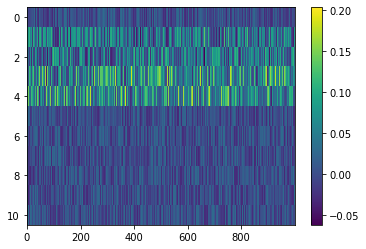

In [668]:
plt.imshow(a, aspect="auto")
plt.colorbar();

In [17]:
a = experiment.get_duty_cycles()
a["cnn1_kwinner"].shape

torch.Size([1, 128, 1, 1])

In [619]:
list(experiment.model.linear1.parameters())[1].shape

torch.Size([1000])

In [669]:
a = list(experiment.model.linear1.parameters())

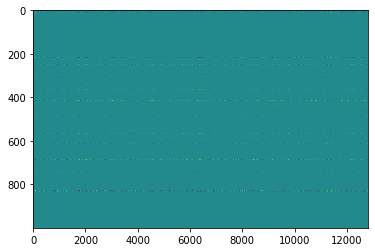

In [670]:
plt.imshow(a[0].grad.detach().cpu().numpy(), aspect="auto")

In [11]:
train_inds = np.arange(1,7).reshape(3,2)
train_inds

array([[1, 2],
       [3, 4],
       [5, 6]])

In [13]:
clear_labels(train_inds[2])

array([ 0,  1,  2,  3,  4,  7,  8,  9, 10])

In [64]:
a = {k[0]: k[1] for k in experiment.model.named_parameters()}

In [65]:
a.keys()

dict_keys(['cnn1_cnn.module.weight', 'cnn1_cnn.module.bias', 'cnn2_cnn.module.weight', 'cnn2_cnn.module.bias', 'linear1.module.weight', 'linear1.module.bias', 'output.weight', 'output.bias'])

In [68]:
["linear" in k for k in a.keys()]

[False, False, False, False, True, True, False, False]

In [31]:
layer_type

'kwinner'

In [16]:
i,j

(4, 0)